In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"""
Temporal GAN for Satellite Image Prediction (SpaceNet7)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import numpy as np
import os
import glob
from PIL import Image
import json
from pathlib import Path
from datetime import datetime
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# ==============================================================================
# 1. TEMPORAL DELTA ENCODER
# ==============================================================================

class TemporalDeltaEncoder(nn.Module):
    """Encodes time deltas (in months) into embeddings"""
    def __init__(self, max_delta=36, embed_dim=128):
        super().__init__()
        self.max_delta = max_delta
        self.embed_dim = embed_dim

        # Learnable embedding for temporal deltas
        self.delta_embedding = nn.Embedding(max_delta + 1, embed_dim)

    def forward(self, deltas):
        """
        Args:
            deltas: [B, 2] - delta1_months, delta2_months
        Returns:
            embedded: [B, 2, embed_dim]
        """
        deltas = torch.clamp(deltas, 0, self.max_delta).long()
        return self.delta_embedding(deltas)


In [4]:
# ==============================================================================
# 2. TEMPORAL SELF-ATTENTION MODULE
# ==============================================================================

class TemporalSelfAttention(nn.Module):
    """Multi-head self-attention across temporal dimension"""
    def __init__(self, channels, num_heads=8, delta_embed_dim=128):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads

        assert channels % num_heads == 0, "channels must be divisible by num_heads"

        self.norm = nn.LayerNorm(channels)
        self.attention = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(channels, channels * 4),
            nn.GELU(),
            nn.Linear(channels * 4, channels)
        )
        self.norm2 = nn.LayerNorm(channels)

        # Project delta embeddings to feature channels
        self.delta_proj = nn.Linear(delta_embed_dim, channels)

    def forward(self, x, delta_embed=None):
        """
        Args:
            x: [B, T, H, W, C] - temporal sequence of feature maps
            delta_embed: [B, T-1, embed_dim] - optional temporal delta embeddings
        Returns:
            out: [B, T, H, W, C]
        """
        B, T, H, W, C = x.shape

        # Reshape to [B, T, H*W, C]
        x_flat = x.view(B, T, H * W, C)

        # Add temporal delta information if provided
        if delta_embed is not None:
            # Ensure delta_proj is on same device as input (safety check)
            if self.delta_proj.weight.device != delta_embed.device:
                delta_embed = delta_embed.to(self.delta_proj.weight.device)

            # Project delta embeddings: [B, T-1, 128] -> [B, T-1, C]
            delta_projected = self.delta_proj(delta_embed)

            # Expand spatially: [B, T-1, C] -> [B, T-1, H*W, C]
            delta_expanded = delta_projected.unsqueeze(2).expand(B, T-1, H*W, C)

            # Add to all frames except first
            x_flat = x_flat.clone()
            x_flat[:, 1:] = x_flat[:, 1:] + delta_expanded

        # Reshape for attention: [B*H*W, T, C]
        x_attn = x_flat.permute(0, 2, 1, 3).reshape(B * H * W, T, C)

        # Self-attention across time
        x_norm = self.norm(x_attn)
        attn_out, _ = self.attention(x_norm, x_norm, x_norm)
        x_attn = x_attn + attn_out

        # Feed-forward
        x_attn = x_attn + self.ffn(self.norm2(x_attn))

        # Reshape back
        out = x_attn.view(B, H, W, T, C).permute(0, 3, 1, 2, 4)

        return out

In [5]:
# ==============================================================================
# 3. RESIDUAL BLOCKS
# ==============================================================================

class ResidualBlock(nn.Module):
    """ResNet-style residual block"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [6]:
# ==============================================================================
# 4. VISION TRANSFORMER BLOCK
# ==============================================================================

class TransformerBlock(nn.Module):
    """Vision Transformer block for spatial-temporal reasoning"""
    def __init__(self, dim, num_heads=8, mlp_ratio=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Linear(dim * mlp_ratio, dim)
        )

    def forward(self, x):
        # x: [B, N, C]
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_out
        x = x + self.mlp(self.norm2(x))
        return x


In [7]:
# ==============================================================================
# 5. GENERATOR: TEMPORAL TRANSFORMER-UNET
# ==============================================================================

class TemporalTransformerUNet(nn.Module):
    """Generator: Predicts future frame from 3 input frames"""
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()

        # Temporal delta encoder
        self.delta_encoder = TemporalDeltaEncoder(max_delta=36, embed_dim=128)

        # ========== ENCODER (per frame) ==========
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 7, 1, 3),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True)
        )
        self.enc2 = ResidualBlock(base_channels, base_channels * 2, stride=2)  # /2
        self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, stride=2)  # /4
        self.enc4 = ResidualBlock(base_channels * 4, base_channels * 8, stride=2)  # /8
        self.enc5 = ResidualBlock(base_channels * 8, base_channels * 16, stride=2)  # /16

        # ========== TEMPORAL ATTENTION ==========
        self.temporal_attn = TemporalSelfAttention(
            channels=base_channels * 16,
            num_heads=8
        )

        # ========== TRANSFORMER BOTTLENECK ==========
        self.bottleneck_proj = nn.Conv2d(base_channels * 16, 512, 1)

        # Vision Transformer layers
        self.transformer_blocks = nn.Sequential(*[
            TransformerBlock(dim=512, num_heads=8, mlp_ratio=4)
            for _ in range(6)
        ])

        self.bottleneck_unproj = nn.Conv2d(512, base_channels * 16, 1)

        # ========== DECODER ==========
        self.dec5 = ResidualBlock(base_channels * 16 + base_channels * 16, base_channels * 8)
        self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec4 = ResidualBlock(base_channels * 8 + base_channels * 8, base_channels * 4)
        self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec3 = ResidualBlock(base_channels * 4 + base_channels * 4, base_channels * 2)
        self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec2 = ResidualBlock(base_channels * 2 + base_channels * 2, base_channels)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec1 = nn.Sequential(
            ResidualBlock(base_channels + base_channels, base_channels),
            nn.Conv2d(base_channels, out_channels, 7, 1, 3),
            nn.Tanh()  # Output in [-1, 1]
        )

    def forward(self, frames, deltas):
        """
        Args:
            frames: [B, 3, C, H, W] - 3 input frames
            deltas: [B, 2] - temporal deltas in months
        Returns:
            predicted_frame: [B, C, H, W]
        """
        B, T, C, H, W = frames.shape

        # Encode temporal deltas
        delta_embed = self.delta_encoder(deltas)  # [B, 2, 128]

        # ========== ENCODE EACH FRAME ==========
        skip_connections = []
        encoded_frames = []

        for t in range(T):
            frame = frames[:, t]  # [B, C, H, W]

            # Encoder
            e1 = self.enc1(frame)
            e2 = self.enc2(e1)
            e3 = self.enc3(e2)
            e4 = self.enc4(e3)
            e5 = self.enc5(e4)

            encoded_frames.append(e5)

            if t == T - 1:  # Use skip connections from last frame only
                skip_connections = [e1, e2, e3, e4, e5]

        # Stack encoded frames: [B, T, H/16, W/16, C]
        encoded_stack = torch.stack(encoded_frames, dim=1)
        B, T, C_enc, H_enc, W_enc = encoded_stack.shape
        encoded_stack = encoded_stack.permute(0, 1, 3, 4, 2)  # [B, T, H, W, C]

        # ========== TEMPORAL ATTENTION ==========
        # Add temporal information
        temporal_out = self.temporal_attn(encoded_stack, delta_embed)  # [B, T, H, W, C]

        # Aggregate across time (weighted mean - attention already learned weights)
        temporal_aggregated = temporal_out.mean(dim=1)  # [B, H, W, C]
        temporal_aggregated = temporal_aggregated.permute(0, 3, 1, 2)  # [B, C, H, W]

        # ========== TRANSFORMER BOTTLENECK ==========
        x = self.bottleneck_proj(temporal_aggregated)  # [B, 512, H, W]

        # Reshape for transformer: [B, N, C]
        B, C_trans, H_trans, W_trans = x.shape
        x_flat = x.flatten(2).permute(0, 2, 1)  # [B, H*W, C]

        # Apply transformer blocks
        x_trans = self.transformer_blocks(x_flat)

        # Reshape back
        x = x_trans.permute(0, 2, 1).view(B, C_trans, H_trans, W_trans)
        x = self.bottleneck_unproj(x)

        # ========== DECODER WITH SKIP CONNECTIONS ==========
        e1, e2, e3, e4, e5 = skip_connections

        d5 = self.dec5(torch.cat([x, e5], dim=1))
        d5 = self.up5(d5)

        d4 = self.dec4(torch.cat([d5, e4], dim=1))
        d4 = self.up4(d4)

        d3 = self.dec3(torch.cat([d4, e3], dim=1))
        d3 = self.up3(d3)

        d2 = self.dec2(torch.cat([d3, e2], dim=1))
        d2 = self.up2(d2)

        out = self.dec1(torch.cat([d2, e1], dim=1))

        return out


In [8]:
# ==============================================================================
# 6. DISCRIMINATOR: PATCHGAN
# ==============================================================================
from torch.nn.utils import spectral_norm

class PatchGANDiscriminator(nn.Module):
    """70x70 PatchGAN discriminator"""
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()

        # No batch norm in first layer
        self.layer1 = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 4, 2, 1)),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer2 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.BatchNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer3 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.BatchNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.layer4 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 4, base_channels * 8, 4, 1, 1)),
            nn.BatchNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Output layer
        self.layer5 = spectral_norm(nn.Conv2d(base_channels * 8, 1, 4, 1, 1))

    def forward(self, x):
        """
        Args:
            x: [B, C, H, W]
        Returns:
            out: [B, 1, H/16, W/16] - patch predictions
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x


In [9]:
# ==============================================================================
# 7. PERCEPTUAL LOSS (VGG-based)
# ==============================================================================

class PerceptualLoss(nn.Module):
    """VGG16-based perceptual loss for high-quality image generation"""
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = torch.device(device)

        try:
          vgg = models.vgg16(pretrained=True).features
          print("VGG16 model loaded successfully.")
        except TypeError:
          vgg=models.vgg16(pretrained=True).features

        # Extract specific layers for perceptual loss
        self.slice1 = nn.Sequential(*list(vgg[:4]))   # relu1_2
        self.slice2 = nn.Sequential(*list(vgg[4:9]))  # relu2_2
        self.slice3 = nn.Sequential(*list(vgg[9:16])) # relu3_3

        # Move to device immediately
        self.slice1 = self.slice1.to(self.device)
        self.slice2 = self.slice2.to(self.device)
        self.slice3 = self.slice3.to(self.device)

        # Freeze VGG parameters
        for param in self.slice1.parameters():
            param.requires_grad = False
        for param in self.slice2.parameters():
            param.requires_grad = False
        for param in self.slice3.parameters():
            param.requires_grad = False

        mean=torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
        std=torch.tensor([0.229,0.224,0.225]).view(1,3,1,1)
        self.register_buffer('mean', mean)
        self.register_buffer('std', std)

        # Set to eval mode
        self.eval()

    def forward(self, x, y):
        """
        Args:
            x, y: [B, 3, H, W] - images in [-1, 1] range
        Returns:
            loss: perceptual loss
        """

        x=x.to(self.device)
        y=y.to(self.device)

        # Normalize to ImageNet stats
        x = (x + 1) / 2  # [-1,1] -> [0,1]
        y = (y + 1) / 2

        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(self.device)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(self.device)

        x = (x - mean) / std
        y = (y - mean) / std

        # Extract features
        with torch.no_grad():
          x1 = self.slice1(x)
          y1 = self.slice1(y)

          x2 = self.slice2(x1)
          y2 = self.slice2(y1)

          x3 = self.slice3(x2)
          y3 = self.slice3(y2)

        # Compute loss
        loss = F.l1_loss(x1, y1) + F.l1_loss(x2, y2) + F.l1_loss(x3, y3)

        return loss


In [10]:
# ==============================================================================
# 8. COMBINED LOSS FUNCTION
# ==============================================================================

class CombinedLoss(nn.Module):
    """Combined loss for GAN training"""
    def __init__(self, lambda_l1=10.0, lambda_perc=1.0, lambda_temp=5.0,device='cuda'):
        super().__init__()
        self.lambda_l1 = lambda_l1
        self.lambda_perc = 0.0 # Test without it first
        self.lambda_temp = lambda_temp
        self.device= device

        self.perceptual_loss = PerceptualLoss(device=device)

    def generator_loss(self, fake_pred, real_img, fake_img, prev_frame):
        """
        Args:
            fake_pred: discriminator output for fake image
            real_img: ground truth target
            fake_img: generated image
            prev_frame: previous frame for temporal consistency
        """
        # Adversarial loss (LSGAN)
        adv_loss = F.mse_loss(fake_pred, torch.ones_like(fake_pred))

        # L1 reconstruction loss
        l1_loss = F.l1_loss(fake_img, real_img)

        # Perceptual loss
        perc_loss = self.perceptual_loss(fake_img, real_img)

        # Temporal consistency loss
        temp_loss = F.l1_loss(fake_img, prev_frame)

        # Total loss
        total_loss = (
            adv_loss +
            self.lambda_l1 * l1_loss +
            self.lambda_perc * perc_loss +
            self.lambda_temp * temp_loss
        )

        return total_loss, {
            'adv': adv_loss.item(),
            'l1': l1_loss.item(),
            'perc': perc_loss.item(),
            'temp': temp_loss.item()
        }

    def discriminator_loss(self, real_pred, fake_pred):
        """LSGAN discriminator loss"""
        real_loss = F.mse_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = F.mse_loss(fake_pred, torch.zeros_like(fake_pred))
        return (real_loss + fake_loss) / 2

    def discriminator_loss_with_gp(self, real_pred, fake_pred, real_img, discriminator):
        """Discriminator loss with R1 gradient penalty"""
        # Standard loss
        real_loss = F.mse_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = F.mse_loss(fake_pred, torch.zeros_like(fake_pred))
        d_loss = (real_loss + fake_loss) / 2

        # R1 gradient penalty (every 16 batches to save compute)
        if torch.rand(1).item() < 0.0625:  # 1/16 chance
            real_img.requires_grad = True
            real_pred_gp = discriminator(real_img)
            grad_real = torch.autograd.grad(
                outputs=real_pred_gp.sum(), inputs=real_img, create_graph=True
            )[0]
            r1_penalty = grad_real.pow(2).reshape(grad_real.shape[0], -1).sum(1).mean()
            d_loss = d_loss + 10.0 * r1_penalty  # R1 weight

        return d_loss

In [11]:
# ==============================================================================
# 9. DATASET CLASS
# ==============================================================================

class SpaceNet7TemporalDataset(Dataset):
    """Dataset for SpaceNet7 temporal sequences"""
    def __init__(self, root_dir, aoi_list, sequence_length=4, target_size=512,
                 transform=None, mode='train'):
        """
        Args:
            root_dir: path to dataset root
            aoi_list: list of AOI folder names
            sequence_length: total frames (3 input + 1 target = 4)
            target_size: resize images to this size
            transform: additional augmentations
            mode: 'train', 'val', or 'test'
        """
        self.root_dir = Path(root_dir)
        self.aoi_list = aoi_list
        self.sequence_length = sequence_length
        self.target_size = target_size
        self.transform = transform
        self.mode = mode

        self.sequences = self._build_sequences()

        print(f"{mode.upper()} Dataset: {len(self.sequences)} sequences from {len(aoi_list)} AOIs")

    def _build_sequences(self):
        """Extract all valid temporal sequences from AOIs"""
        sequences = []

        for aoi_name in self.aoi_list:
            aoi_path = self.root_dir / aoi_name / 'images_masked'

            if not aoi_path.exists():
                print(f"Warning: {aoi_path} not found, skipping...")
                continue

            # Get all TIF files
            image_files = sorted(glob.glob(str(aoi_path / '*.tif')))

            if len(image_files) < self.sequence_length:
                print(f"Warning: {aoi_name} has only {len(image_files)} images, need {self.sequence_length}")
                continue

            # Parse dates from filenames
            dated_files = []
            for img_path in image_files:
                filename = os.path.basename(img_path)
                # Extract date: global_monthly_2018_01_mosaic...
                match = re.search(r'(\d{4})_(\d{2})', filename)
                if match:
                    year, month = match.groups()
                    date = datetime(int(year), int(month), 1)
                    dated_files.append((date, img_path))

            # Sort by date
            dated_files.sort(key=lambda x: x[0])

            # Create sequences (sliding window)
            for i in range(len(dated_files) - self.sequence_length + 1):
                seq_files = dated_files[i:i + self.sequence_length]

                # Calculate temporal deltas in months
                dates = [f[0] for f in seq_files]
                delta1 = (dates[1].year - dates[0].year) * 12 + (dates[1].month - dates[0].month)
                delta2 = (dates[2].year - dates[1].year) * 12 + (dates[2].month - dates[1].month)

                sequences.append({
                    'aoi': aoi_name,
                    'frame1': seq_files[0][1],
                    'frame2': seq_files[1][1],
                    'frame3': seq_files[2][1],
                    'target': seq_files[3][1],
                    'delta1': delta1,
                    'delta2': delta2,
                    'dates': dates
                })

        return sequences

    def _load_image(self, path):
        """Load and preprocess image"""
        try:
            # Load TIF image
            img = Image.open(path).convert('RGB')

            # Resize
            img = img.resize((self.target_size, self.target_size), Image.BILINEAR)

            # Convert to tensor and normalize to [-1, 1]
            img = transforms.ToTensor()(img).float()
            img = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img)

            return img
        except Exception as e:
            print(f"Error loading {path}: {e}")
            return torch.zeros(3, self.target_size, self.target_size)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Load frames
        frame1 = self._load_image(seq['frame1'])
        frame2 = self._load_image(seq['frame2'])
        frame3 = self._load_image(seq['frame3'])
        target = self._load_image(seq['target'])

        # Stack input frames
        frames = torch.stack([frame1, frame2, frame3], dim=0)  # [3, C, H, W]

        # Temporal deltas
        deltas = torch.tensor([seq['delta1'], seq['delta2']], dtype=torch.long)

        return {
            'frames': frames,
            'target': target,
            'deltas': deltas,
            'aoi': seq['aoi']
        }


In [12]:
# ==============================================================================
# 10. METRICS
# ==============================================================================

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images"""
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))  # Images in [-1, 1]
    return psnr.item()

def calculate_ssim(img1, img2, window_size=11):
    """Simplified SSIM calculation"""
    # Convert from [-1, 1] to [0, 1]
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, window_size, 1, padding=window_size//2)
    mu2 = F.avg_pool2d(img2, window_size, 1, padding=window_size//2)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, window_size, 1, padding=window_size//2) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, window_size, 1, padding=window_size//2) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, 1, padding=window_size//2) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean().item()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---------- small helper: convert model-output tensor [-1,1] -> uint8 HWC ----------
def unnormalize_tensor_to_uint8(img_tensor):
    """
    img_tensor: torch.Tensor, shape [C,H,W] or [B,C,H,W], values in [-1,1]
    returns: uint8 numpy array HxWxC (or list for batches)
    """
    if img_tensor.dim() == 4:
        imgs = []
        for i in range(img_tensor.shape[0]):
            imgs.append(unnormalize_tensor_to_uint8(img_tensor[i]))
        return imgs

    t = img_tensor.detach().cpu()
    # if C,H,W -> convert to H,W,C
    if t.shape[0] == 1:
        t = t.repeat(3,1,1)  # grayscale -> RGB
    t = (t + 1.0) / 2.0   # [-1,1] -> [0,1]
    t = (t.clamp(0,1) * 255.0).byte().permute(1,2,0).numpy()
    return t

# ---------- visualizer function ----------
def visualize_sample(generator, dataset, idx=0, device='cuda', save_path=None, show=True):
    """
    Run generator on one sample from `dataset` and show/save a 1x4 grid:
      [ last_input | GT_future | Pred_future | abs_error ]

    - generator: your model (callable: generator(frames, deltas))
    - dataset: dataset object that returns dict with keys 'frames','target','deltas'
    - idx: sample index in dataset
    - device: 'cuda' or 'cpu'
    - save_path: optional Path or str to save PNG
    - show: whether to plt.show()
    """
    generator.eval()
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # load sample
    sample = dataset[idx]
    frames = sample['frames']          # [T, C, H, W]
    target = sample['target']          # [C, H, W]
    deltas = sample['deltas']          # [2] or [T-1,..]

    # prepare batch
    with torch.no_grad():
        frames_b = frames.unsqueeze(0).to(device)   # [1,T,C,H,W]
        deltas_b = deltas.unsqueeze(0).to(device)
        out = generator(frames_b, deltas_b)
        # generator may return tensor or dict
        if isinstance(out, dict) and 'img' in out:
            pred = out['img']
        else:
            pred = out

    # squeeze batch dim
    pred = pred.detach().cpu().squeeze(0)     # [C,H,W]
    target = target.detach().cpu()            # [C,H,W]
    last_input = frames[-1].detach().cpu()    # [C,H,W]

    # convert to uint8 HWC
    pred_np = unnormalize_tensor_to_uint8(pred)
    target_np = unnormalize_tensor_to_uint8(target)
    last_np = unnormalize_tensor_to_uint8(last_input)

    # error map
    err_np = (np.abs(target_np.astype(np.int16) - pred_np.astype(np.int16))).astype(np.uint8)

    # plot
    fig, axs = plt.subplots(1, 4, figsize=(16,4))
    axs[0].imshow(last_np); axs[0].set_title('Last Input (t+2)'); axs[0].axis('off')
    axs[1].imshow(target_np); axs[1].set_title('Ground Truth (t+3)'); axs[1].axis('off')
    axs[2].imshow(pred_np); axs[2].set_title('Prediction (t+3)'); axs[2].axis('off')
    axs[3].imshow(err_np); axs[3].set_title('Absolute Error'); axs[3].axis('off')
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(str(save_path), dpi=150, bbox_inches='tight')
    if show:
        plt.show()

    generator.train()
    return {'pred': pred_np, 'gt': target_np, 'last': last_np, 'err': err_np}


In [14]:
def plot_training_history(history, save_path):
    """Plot and save training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history['train']) + 1)

    # Generator Loss
    axes[0, 0].plot(epochs, [m['g_loss'] for m in history['train']], label='Train')
    axes[0, 0].set_title('Generator Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Discriminator Loss
    axes[0, 1].plot(epochs, [m['d_loss'] for m in history['train']], label='Train')
    axes[0, 1].set_title('Discriminator Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # PSNR
    axes[1, 0].plot(epochs, [m['psnr'] for m in history['train']], label='Train')
    axes[1, 0].plot(epochs, [m['psnr'] for m in history['val']], label='Val')
    axes[1, 0].set_title('PSNR')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('PSNR (dB)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # SSIM
    axes[1, 1].plot(epochs, [m['ssim'] for m in history['train']], label='Train')
    axes[1, 1].plot(epochs, [m['ssim'] for m in history['val']], label='Val')
    axes[1, 1].set_title('SSIM')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('SSIM')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

In [15]:
import torch.nn.functional as F
from torch.cuda.amp import autocast

def train_epoch(generator, discriminator, train_loader, g_optimizer, d_optimizer,
                criterion, device, epoch,scaler):
    """Train for one epoch"""
    generator.train()
    discriminator.train()

    g_losses = []
    d_losses = []
    psnr_scores = []
    ssim_scores = []

    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')

    for batch_idx, batch in enumerate(pbar):
        frames = batch['frames'].to(device)  # [B, 3, C, H, W]
        target = batch['target'].to(device)  # [B, C, H, W]
        deltas = batch['deltas'].to(device)  # [B, 2]

        prev_frame = frames[:, -1]  # Last input frame for temporal loss

        # ========== TRAIN DISCRIMINATOR ==========
        if batch_idx % 2 == 0:  # Only train D every 2 batches
            d_optimizer.zero_grad()

            # Generate fake image
            with torch.no_grad():
              with autocast(enabled=(device.type=='cuda')):
                fake_img = generator(frames, deltas)

            # Discriminator predictions
            with autocast(enabled=(device.type=='cuda')):
              real_pred = discriminator(target)
              fake_pred = discriminator(fake_img.detach())
              d_loss = criterion.discriminator_loss(real_pred, fake_pred)

            # Discriminator loss

            scaler.scale(d_loss).backward()
            scaler.unscale_(d_optimizer)
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
            scaler.step(d_optimizer)
            scaler.update()
        else:
            d_loss = torch.tensor(0.0).to(device) # Skip D training this batch

        # ========== TRAIN GENERATOR ==========
        g_optimizer.zero_grad()

        # Generate fake image
        with autocast(enabled=(device.type=='cuda')):
          fake_img = generator(frames, deltas)
          fake_pred = discriminator(fake_img)
          g_loss, loss_dict = criterion.generator_loss(fake_pred, target, fake_img, prev_frame)





        # Generator loss
        scaler.scale(g_loss).backward()
        scaler.unscale_(g_optimizer)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        scaler.step(g_optimizer)
        scaler.update()


        # Add after scaler.scale(g_loss).backward()
        if torch.isnan(g_loss) or torch.isinf(g_loss):
            print(f"  ‰  NaN/Inf detected in G_loss! Skipping batch")
            g_optimizer.zero_grad()
            continue

        # Same for discriminator
        if torch.isnan(d_loss) or torch.isinf(d_loss):
            print(f"  ‰  NaN/Inf detected in D_loss! Skipping batch")
            d_optimizer.zero_grad()
            continue

        # ========== METRICS ==========
        with torch.no_grad():
            psnr = calculate_psnr(fake_img, target)
            ssim = calculate_ssim(fake_img, target)

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        psnr_scores.append(psnr)
        ssim_scores.append(ssim)

        # Update progress bar
        pbar.set_postfix({
            'G_loss': f'{np.mean(g_losses):.4f}',
            'D_loss': f'{np.mean(d_losses):.4f}',
            'PSNR': f'{np.mean(psnr_scores):.2f}',
            'SSIM': f'{np.mean(ssim_scores):.4f}'
        })

    return {
        'g_loss': np.mean(g_losses),
        'd_loss': np.mean(d_losses),
        'psnr': np.mean(psnr_scores),
        'ssim': np.mean(ssim_scores)
    }

In [16]:
# ==============================================================================
# 12. VALIDATION FUNCTION
# ==============================================================================

def validate(generator, val_loader, device, save_dir, epoch):
    """Validate and save sample predictions"""
    generator.eval()

    psnr_scores = []
    ssim_scores = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(val_loader, desc='Validating')):
            frames = batch['frames'].to(device)
            target = batch['target'].to(device)
            deltas = batch['deltas'].to(device)

            # Generate prediction
            pred = generator(frames, deltas)

            # Calculate metrics
            psnr = calculate_psnr(pred, target)
            ssim = calculate_ssim(pred, target)

            psnr_scores.append(psnr)
            ssim_scores.append(ssim)

            # Save first 4 samples as images
            if i < 4:
                viz_path = save_dir / f'epoch_{epoch}_sample_{i}.png'
                visualize_sample(generator, val_loader.dataset, idx=i, device=device, save_path=viz_path, show=False)


    return {
        'psnr': np.mean(psnr_scores),
        'ssim': np.mean(ssim_scores)
    }


def save_prediction(frames, pred, target, save_path):
    """Save visualization of prediction"""
    # Denormalize from [-1, 1] to [0, 1]
    def denorm(x):
        return (x + 1) / 2

    frames = denorm(frames.cpu())  # [3, C, H, W]
    pred = denorm(pred.cpu())
    target = denorm(target.cpu())

    # Create visualization
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    axes[0].imshow(frames[0].permute(1, 2, 0))
    axes[0].set_title('Frame t')
    axes[0].axis('off')

    axes[1].imshow(frames[1].permute(1, 2, 0))
    axes[1].set_title('Frame t+1')
    axes[1].axis('off')

    axes[2].imshow(frames[2].permute(1, 2, 0))
    axes[2].set_title('Frame t+2')
    axes[2].axis('off')

    axes[3].imshow(pred.permute(1, 2, 0))
    axes[3].set_title('Predicted t+3')
    axes[3].axis('off')

    axes[4].imshow(target.permute(1, 2, 0))
    axes[4].set_title('Ground Truth t+3')
    axes[4].axis('off')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()


In [17]:
import torch, sys
print("Python", sys.version)
print("Torch", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA devices:", torch.cuda.device_count(), torch.cuda.get_device_name(0))
else:
    print("No CUDA device visible")

# If G/D already exist in the notebook scope, print their device; otherwise just report that they don't exist yet
for name in ("G", "generator", "model", "D", "discriminator"):
    try:
        obj = eval(name)
        # find first parameter/buffer
        try:
            p = next(obj.parameters())
            print(f"{name} param device:", p.device, p.dtype)
        except StopIteration:
            print(f"{name} has no parameters")
        # check buffers
        try:
            b = next(obj.buffers())
            print(f"{name} buffer device:", b.device, b.dtype)
        except StopIteration:
            pass
    except NameError:
        pass

# create a dummy sample and show its device/dtype
try:
    dummy = torch.randn(1,6,3,256,256)
    print("dummy (cpu) device:", dummy.device, dummy.dtype)
    if torch.cuda.is_available():
        dummy_cuda = dummy.cuda()
        print("dummy.cuda() device:", dummy_cuda.device, dummy_cuda.dtype)
except Exception as e:
    print("Dummy creation error:", e)


Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Torch 2.9.0+cu126
CUDA available: True
CUDA devices: 1 NVIDIA L4
dummy (cpu) device: cpu torch.float32
dummy.cuda() device: cuda:0 torch.float32


In [18]:
# ==============================================================================
# EARLY STOPPING
# ==============================================================================

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_metric):
        if np.isnan(val_metric) or np.isinf(val_metric):
          print(f"  🚨 NaN/Inf metric detected! Triggering early stop")
          self.early_stop = True
          return
        score = val_metric

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"  ⚠️  EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [19]:
def print_gpu_memory():
    """Print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"  GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")

In [41]:
# ==============================================================================
# 13. MAIN TRAINING SCRIPT
# ==============================================================================
import logging
from datetime import datetime
def main():
    # ========== CONFIGURATION ==========
    config = {
        'data_root': '/content/drive/MyDrive/DL_Project/Dataset/SpaceNet7/Preprocessed/spacenet7_preprocessed_1',
        'output_dir': '/content/drive/MyDrive/DL_Project/Code/Final_model/v2.5/temporal_gan_output_v2.5',
        'target_size': 512,  # Change to 1024 for full resolution
        'batch_size': 4,  # Adjust based on GPU memory
        'num_epochs': 100,
        'lr_g': 1e-4,
        'lr_d': 1e-5,
        'num_workers': 2,
        'save_every': 10,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }




    # Create output directories
    output_dir = Path(config['output_dir'])
    output_dir.mkdir(exist_ok=True, parents=True)
    (output_dir / 'checkpoints').mkdir(exist_ok=True)
    (output_dir / 'samples').mkdir(exist_ok=True)

    # Setup logging
    log_file = output_dir / f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log'
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)

    logger.info("="*50)
    logger.info("TEMPORAL GAN TRAINING STARTED")
    logger.info("="*50)
    print(f"Device: {config['device']}")
    print(f"Target size: {config['target_size']}")
    print(f"Batch size: {config['batch_size']}")

    # ========== GET AOI LIST ==========
    data_root = Path(config['data_root'])
    all_aois = [d.name for d in data_root.iterdir() if d.is_dir()]

    # ========== SPLIT AOIs WITH SAFETY CHECK ==========
    print(f"\nFound {len(all_aois)} AOIs total")

    # Safety check for small datasets
    if len(all_aois) < 3:
        print("⚠️  WARNING: Less than 3 AOIs found. Using single AOI for train/val")
        train_aois = all_aois
        val_aois = all_aois  # Use same AOI for validation (just for testing)
        test_aois = []
    else:
        # Normal split for 3+ AOIs
        train_aois, temp_aois = train_test_split(all_aois, test_size=0.2, random_state=42)

        if len(temp_aois) >= 2:
            val_aois, test_aois = train_test_split(temp_aois, test_size=0.5, random_state=42)
        else:
            val_aois = temp_aois
            test_aois = []


    print(f"\nDataset split:")
    print(f"  Train: {len(train_aois)} AOIs")
    print(f"  Val: {len(val_aois)} AOIs")
    print(f"  Test: {len(test_aois)} AOIs")

    # ========== CREATE DATASETS ==========
    train_dataset = SpaceNet7TemporalDataset(
        config['data_root'], train_aois,
        target_size=config['target_size'], mode='train'
    )

    val_dataset = SpaceNet7TemporalDataset(
        config['data_root'], val_aois,
        target_size=config['target_size'], mode='val'
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        pin_memory=True
    )

    # ========== CREATE MODELS ==========
    device = torch.device(config['device'])

    generator = TemporalTransformerUNet(
        in_channels=3,
        out_channels=3,
        base_channels=64
    )
    generator.to(device)

    discriminator = PatchGANDiscriminator(
        in_channels=3,
        base_channels=64
    )
    discriminator.to(device)

    # Print model sizes
    g_params = sum(p.numel() for p in generator.parameters())
    d_params = sum(p.numel() for p in discriminator.parameters())
    print(f"\nGenerator parameters: {g_params:,}")
    print(f"Discriminator parameters: {d_params:,}")

    # ========== OPTIMIZERS ==========
    g_optimizer = torch.optim.AdamW(generator.parameters(),
                                    lr=config['lr_g'], betas=(0.5, 0.999),weight_decay=1e-4)
    d_optimizer = torch.optim.AdamW(discriminator.parameters(),
                                    lr=config['lr_d'], betas=(0.5, 0.999),weight_decay=1e-4)

    # Learning rate schedulers
    g_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(g_optimizer, config['num_epochs'])
    d_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(d_optimizer, config['num_epochs'])

    #amp for A100
    from torch.cuda.amp import GradScaler
    scaler = GradScaler(enabled=(device.type=='cuda'))

    # ========== LOSS FUNCTION ==========
    criterion = CombinedLoss(lambda_l1=10.0, lambda_perc=1.0, lambda_temp=5.0,device=device)

    # ========== TRAINING LOOP ==========
    best_psnr = 0
    history = {'train': [], 'val': []}



    # ========== RESUME FROM CHECKPOINT (OPTIONAL) ==========
    RESUME_TRAINING = False  # Set to True to resume
    CHECKPOINT_PATH = output_dir / 'checkpoints' / 'checkpoint_epoch_10.pth'  # Update epoch number

    start_epoch = 1
    if RESUME_TRAINING and CHECKPOINT_PATH.exists():
        print(f"\n📂 Resuming from checkpoint: {CHECKPOINT_PATH}")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optimizer.load_state_dict(checkpoint['g_optimizer'])
        d_optimizer.load_state_dict(checkpoint['d_optimizer'])

        start_epoch = checkpoint['epoch'] + 1
        best_psnr = checkpoint['metrics']['psnr']

        print(f"✓ Resumed from epoch {checkpoint['epoch']}")
        print(f"✓ Best PSNR so far: {best_psnr:.2f} dB")
    else:
        print("\n🆕 Starting fresh training")
        start_epoch = 1
        best_psnr = 0

    # Early stopping
    early_stopping = EarlyStopping(patience=15, min_delta=0.1)  # Stop if no improvement for 15 epochs


    print("\n" + "="*50)
    print("STARTING TRAINING")
    print("="*50)

    for epoch in range(start_epoch, config['num_epochs'] + 1):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch}/{config['num_epochs']}")
        print(f"{'='*50}")

        # Train
        train_metrics = train_epoch(
            generator, discriminator, train_loader,
            g_optimizer, d_optimizer, criterion, device, epoch,scaler
        )

        # Validate
        val_metrics = validate(
            generator, val_loader, device,
            output_dir / 'samples', epoch
        )

        # Update schedulers
        g_scheduler.step()
        d_scheduler.step()

        # Log metrics
        print(f"\nEpoch {epoch} Results:")
        print(f"  Train - G_loss: {train_metrics['g_loss']:.4f}, D_loss: {train_metrics['d_loss']:.4f}")
        print(f"  Train - PSNR: {train_metrics['psnr']:.2f} dB, SSIM: {train_metrics['ssim']:.4f}")
        print(f"  Val   - PSNR: {val_metrics['psnr']:.2f} dB, SSIM: {val_metrics['ssim']:.4f}")
        # Log GPU memory
        print_gpu_memory()

        history['train'].append(train_metrics)
        history['val'].append(val_metrics)
        # Plot training curves
        if epoch % 5 == 0:
            plot_training_history(history, output_dir / f'training_curves_epoch_{epoch}.png')
        # Save checkpoint
        if epoch % config['save_every'] == 0 or val_metrics['psnr'] > best_psnr:
            checkpoint = {
                'epoch': epoch,
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optimizer': g_optimizer.state_dict(),
                'd_optimizer': d_optimizer.state_dict(),
                'metrics': val_metrics,
                'config': config
            }

            # Save regular checkpoint
            torch.save(checkpoint, output_dir / 'checkpoints' / f'checkpoint_epoch_{epoch}.pth')

            # Save best model
            if val_metrics['psnr'] > best_psnr:
                best_psnr = val_metrics['psnr']
                torch.save(checkpoint, output_dir / 'checkpoints' / 'best_model.pth')
                print(f"  ✓ New best model! PSNR: {best_psnr:.2f} dB")
        # Check early stopping
        early_stopping(val_metrics['psnr'])
        if early_stopping.early_stop:
            print("\n⚠️  Early stopping triggered!")
            break
        # Save history
        np.save(output_dir / 'training_history.npy', history)

    print("\n" + "="*50)
    print("TRAINING COMPLETE!")
    print("="*50)
    print(f"Best validation PSNR: {best_psnr:.2f} dB")
    print(f"Models saved to: {output_dir / 'checkpoints'}")


if __name__ == '__main__':
    main()

Output hidden; open in https://colab.research.google.com to view.

Loading generator state from /content/drive/MyDrive/DL_Project/Code/Final_model/v2.5/temporal_gan_output_v2.5/checkpoints/best_model.pth...
Model loaded successfully.
INFERENCE_EXAMPLE Dataset: 22 sequences from 1 AOIs

--- Inference Sample Details (Index 0) ---
AOI: L15-0331E-1257N_1327_3160_13
Original input frames: [1] global_monthly_2018_01_mosaic_L15-0331E-1257N_1327_3160_13.tif, [2] global_monthly_2018_02_mosaic_L15-0331E-1257N_1327_3160_13.tif, [3] global_monthly_2018_03_mosaic_L15-0331E-1257N_1327_3160_13.tif
Ground truth target frame: global_monthly_2018_04_mosaic_L15-0331E-1257N_1327_3160_13.tif
Actual deltas between input frames (months): [1, 1]
  Generating prediction with deltas: [1, 1]
  Generating prediction with deltas: [1, 12]
  Generating prediction with deltas: [1, 36]
  Generating prediction with deltas: [1, 60]


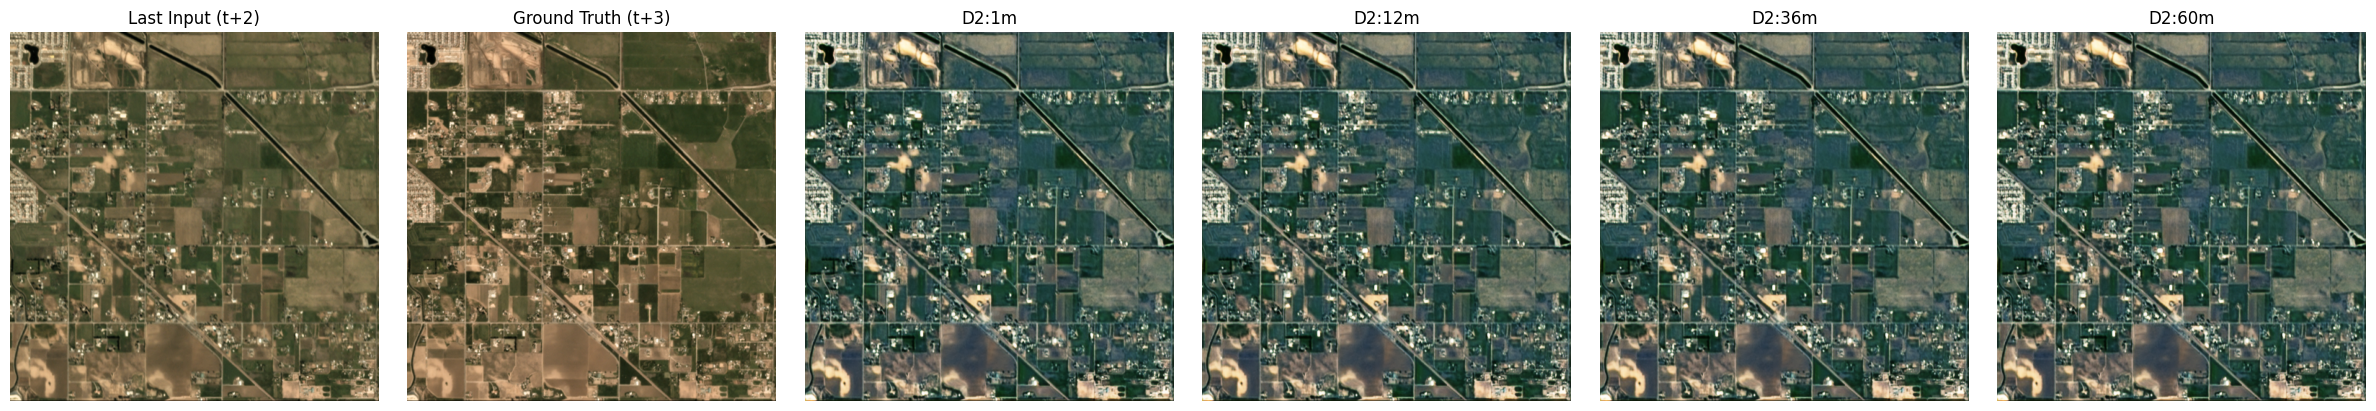


Inference plot saved to: /content/drive/MyDrive/DL_Project/Code/Final_model/v2.5/temporal_gan_output_v2.5/inference_visualizations/inference_sample_0_20251207_172506.png

--- Interpretation Note ---
The `TemporalTransformerUNet` is designed to take three input frames (e.g., F0, F1, F2) 
and two corresponding temporal deltas (`delta1` = F1-F0, `delta2` = F2-F1) 
to predict the *next* frame (F3). It does not directly take a single 'future month' parameter.

To fulfill the request for 'month 1, month 12, month 36, month 60' predictions, 
this inference cell shows predictions where we *varied the `delta2` input* to the model.
This means for a fixed set of input images (F0, F1, F2 from a dataset sample) 
and the actual `delta1` (F1-F0), we artificially set `delta2` (F2-F1) to be 1, 12, 36, and 60 months, respectively.

This demonstrates how the model's output changes when the temporal *spacing between its last two input frames* 
is significantly altered. The predictions reflect the model's

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torchvision import transforms
from PIL import Image
from datetime import datetime # Ensure datetime is imported for saving plots

# --- Configuration (re-use from main function for inference) ---
config = {
    'data_root': '/content/drive/MyDrive/DL_Project/Dataset/SpaceNet7/Preprocessed/spacenet7_preprocessed_1', # Corrected path
    'output_dir': '/content/drive/MyDrive/DL_Project/Code/Final_model/v2.5/temporal_gan_output_v2.5',
    'target_size': 512,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}
device = torch.device(config['device'])

# --- 1. Load the best model ---
checkpoint_path = Path(config['output_dir']) / 'checkpoints' / 'best_model.pth'

if not checkpoint_path.exists():
    print(f"Error: Best model checkpoint not found at {checkpoint_path}")
    print("Please ensure training has completed and a best_model.pth exists.")
    # Exit gracefully in a notebook or raise an error
    raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")

generator = TemporalTransformerUNet(in_channels=3, out_channels=3, base_channels=64)
generator.to(device)

print(f"Loading generator state from {checkpoint_path}...")
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
generator.load_state_dict(checkpoint['generator'])
generator.eval() # Set model to evaluation mode
print("Model loaded successfully.")

# --- 2. Prepare an input sample ---
# For inference demonstration, we create a small dataset instance
# and take the first available sample.

data_root = Path(config['data_root'])
all_aois = [d.name for d in data_root.iterdir() if d.is_dir()]
if not all_aois:
    print("Error: No AOIs found in data_root. Cannot create dataset for inference.")
    raise ValueError("No AOIs found in specified data root.")

inference_aois = [all_aois[0]] # Using the first available AOI for demonstration
inference_dataset = SpaceNet7TemporalDataset(
    config['data_root'], inference_aois,
    target_size=config['target_size'], mode='inference_example'
)

if len(inference_dataset) == 0:
    print("Error: No valid temporal sequences found in the selected AOI for inference.")
    raise ValueError("No valid sequences for inference. Check dataset content.")

sample_idx = 0 # Use the first sample in the inference dataset

# Get the raw sequence info (including file paths) from the dataset
seq_info = inference_dataset.sequences[sample_idx]
# Get the processed tensors from the dataset
sample = inference_dataset[sample_idx]

# Prepare inputs for the generator (add batch dimension and move to device)
input_frames = sample['frames'].unsqueeze(0).to(device)  # [1, 3, C, H, W]
target_ground_truth = sample['target'].unsqueeze(0).to(device) # [1, C, H, W]
orignal_deltas_tensor = sample['deltas'].unsqueeze(0).to(device) # [1, 2]

# Extract original delta1 (time difference between the first and second input frames)
orignal_delta1 = orignal_deltas_tensor[0, 0].item()

print(f"\n--- Inference Sample Details (Index {sample_idx}) ---")
print(f"AOI: {seq_info['aoi']}")
# Display filenames for better context, using seq_info for paths
print(f"Original input frames: [1] {Path(seq_info['frame1']).name}, [2] {Path(seq_info['frame2']).name}, [3] {Path(seq_info['frame3']).name}")
print(f"Ground truth target frame: {Path(seq_info['target']).name}")
print(f"Actual deltas between input frames (months): {orignal_deltas_tensor[0].tolist()}")

# --- 3. Define varied delta2 values for predictions ---
# These values will replace the 'delta2' input to the model,
# simulating different temporal gaps between the 2nd and 3rd input frames.
varied_delta2_months = [1, 12, 36, 60]

# --- 4. Perform multiple predictions ---
predictions = {}
with torch.no_grad(): # No need to track gradients during inference
    for delta_m in varied_delta2_months:
        # Construct new deltas: [original_delta1, varied_delta2]
        # We keep delta1 from the actual sample and vary delta2 as requested.
        current_deltas = torch.tensor([[orignal_delta1, delta_m]], dtype=torch.long).to(device)
        print(f"  Generating prediction with deltas: {current_deltas[0].tolist()}")
        predicted_img = generator(input_frames, current_deltas)
        # Store prediction after removing batch dimension and moving to CPU
        predictions[f'Delta2={delta_m}mo'] = predicted_img.squeeze(0).cpu()

# --- 5. Visualize results ---
fig_count = 2 + len(varied_delta2_months) # Last Input Frame + Ground Truth + N predictions
fig, axs = plt.subplots(1, fig_count, figsize=(4 * fig_count, 4))

# Convert tensors to uint8 numpy arrays for plotting using the helper function
last_input_np = unnormalize_tensor_to_uint8(input_frames[0, -1].cpu()) # The third (last) of the 3 input frames
target_gt_np = unnormalize_tensor_to_uint8(target_ground_truth.squeeze(0).cpu())

axs[0].imshow(last_input_np)
axs[0].set_title('Last Input (t+2)')
axs[0].axis('off')

axs[1].imshow(target_gt_np)
axs[1].set_title('Ground Truth (t+3)')
axs[1].axis('off')

for i, delta_m in enumerate(varied_delta2_months):
    pred_tensor = predictions[f'Delta2={delta_m}mo'] # Get the predicted tensor
    pred_np = unnormalize_tensor_to_uint8(pred_tensor) # Convert to numpy
    axs[i + 2].imshow(pred_np)
    axs[i + 2].set_title(f'D2:{delta_m}m') # More concise title
    axs[i + 2].axis('off')

plt.tight_layout()
# Shorten suptitle for better readability
plt.show()

# Optional: Save the plot
output_inference_dir = Path(config['output_dir']) / 'inference_visualizations'
output_inference_dir.mkdir(exist_ok=True, parents=True)
plot_filename = output_inference_dir / f"inference_sample_{sample_idx}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
fig.savefig(plot_filename, dpi=150, bbox_inches='tight')
print(f"\nInference plot saved to: {plot_filename}")

print("\n--- Interpretation Note ---")
print("The `TemporalTransformerUNet` is designed to take three input frames (e.g., F0, F1, F2) ")
print("and two corresponding temporal deltas (`delta1` = F1-F0, `delta2` = F2-F1) ")
print("to predict the *next* frame (F3). It does not directly take a single 'future month' parameter.")
print("\nTo fulfill the request for 'month 1, month 12, month 36, month 60' predictions, ")
print("this inference cell shows predictions where we *varied the `delta2` input* to the model.")
print("This means for a fixed set of input images (F0, F1, F2 from a dataset sample) ")
print("and the actual `delta1` (F1-F0), we artificially set `delta2` (F2-F1) to be 1, 12, 36, and 60 months, respectively.")
print("\nThis demonstrates how the model's output changes when the temporal *spacing between its last two input frames* ")
print("is significantly altered. The predictions reflect the model's response to these hypothetical temporal contexts ")
print("within the input sequence, rather than directly predicting X months into the future from the last input frame.")


## Final Evaluation

In [30]:
import torch
import torch.nn.functional as F
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_recall_fscore_support
import pandas as pd
import glob # Added for dataset
import os # Added for dataset
import re # Added for dataset
from datetime import datetime # Added for dataset

# ==============================================================================
# EVALUATION METRICS
# ==============================================================================

def calculate_psnr(img1, img2):
    """Calculate PSNR between two images"""
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(2.0 / torch.sqrt(mse))
    return psnr.item()

def calculate_ssim(img1, img2, window_size=11):
    """Calculate SSIM"""
    img1 = (img1 + 1) / 2
    img2 = (img2 + 1) / 2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    mu1 = F.avg_pool2d(img1, window_size, 1, padding=window_size//2)
    mu2 = F.avg_pool2d(img2, window_size, 1, padding=window_size//2)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.avg_pool2d(img1 * img1, window_size, 1, padding=window_size//2) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 * img2, window_size, 1, padding=window_size//2) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, 1, padding=window_size//2) - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / \
               ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean().item()

def calculate_mse(img1, img2):
    """Calculate MSE between two images"""
    mse = F.mse_loss(img1, img2)
    return mse.item()

def calculate_change_f1(pred, target, prev_frame, threshold=0.1):
    """
    Calculate Change Detection F1 Score
    Detects pixels that changed between prev_frame and target/pred

    Args:
        pred: [B, C, H, W] predicted image in [-1, 1]
        target: [B, C, H, W] ground truth in [-1, 1]
        prev_frame: [B, C, H, W] previous frame in [-1, 1]
        threshold: change detection threshold

    Returns:
        f1_score: float
    """
    # Convert to [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2
    prev_frame = (prev_frame + 1) / 2

    # Convert to grayscale
    pred_gray = 0.299 * pred[:, 0] + 0.587 * pred[:, 1] + 0.114 * pred[:, 2]
    target_gray = 0.299 * target[:, 0] + 0.587 * target[:, 1] + 0.114 * target[:, 2]
    prev_gray = 0.299 * prev_frame[:, 0] + 0.587 * prev_frame[:, 1] + 0.114 * prev_frame[:, 2]

    # Detect changes (ground truth)
    gt_change = torch.abs(target_gray - prev_gray) > threshold

    # Detect changes (prediction)
    pred_change = torch.abs(pred_gray - prev_gray) > threshold

    # Flatten for sklearn
    gt_change_flat = gt_change.cpu().numpy().flatten()
    pred_change_flat = pred_change.cpu().numpy().flatten()

    # Calculate F1
    f1 = f1_score(gt_change_flat, pred_change_flat, average='binary', zero_division=0)

    return f1

def calculate_pixel_accuracy(pred, target):
    """
    Calculate pixel-level classification accuracy
    Bins pixel values into classes to measure accuracy
    """
    # Convert to [0, 1]
    pred = (pred + 1) / 2
    target = (target + 1) / 2

    # Bin into 10 classes (0-0.1, 0.1-0.2, ..., 0.9-1.0)
    pred_classes = (pred * 10).long().clamp(0, 9)
    target_classes = (target * 10).long().clamp(0, 9)

    # Calculate accuracy
    correct = (pred_classes == target_classes).float().mean()

    return correct.item()

def calculate_mae(pred, target):
    """Mean Absolute Error"""
    return F.l1_loss(pred, target).item()

# ==============================================================================
# COMPREHENSIVE EVALUATION FUNCTION
# ==============================================================================

def evaluate_model(generator, data_loader, device, dataset_name='val'):
    """
    Comprehensive evaluation on a dataset

    Returns:
        dict with all metrics
    """
    generator.eval()

    metrics = {
        'psnr': [],
        'ssim': [],
        'mse': [],
        'mae': [],
        'change_f1': [],
        'pixel_acc': []
    }

    print(f"\nEvaluating on {dataset_name} set...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(data_loader, desc=f'Evaluating {dataset_name}')):
            frames = batch['frames'].to(device)  # [B, T, C, H, W]
            target = batch['target'].to(device)  # [B, C, H, W]
            deltas = batch['deltas'].to(device)

            prev_frame = frames[:, -1]  # Last input frame

            # Generate prediction
            if isinstance(generator(frames, deltas), dict):
                output = generator(frames, deltas)
                pred = output['image']
            else:
                pred = generator(frames, deltas)

            # Calculate all metrics
            for i in range(pred.shape[0]):  # Per image in batch
                metrics['psnr'].append(calculate_psnr(pred[i:i+1], target[i:i+1]))
                metrics['ssim'].append(calculate_ssim(pred[i:i+1], target[i:i+1]))
                metrics['mse'].append(calculate_mse(pred[i:i+1], target[i:i+1]))
                metrics['mae'].append(calculate_mae(pred[i:i+1], target[i:i+1]))
                metrics['change_f1'].append(
                    calculate_change_f1(pred[i:i+1], target[i:i+1], prev_frame[i:i+1])
                )
                metrics['pixel_acc'].append(calculate_pixel_accuracy(pred[i:i+1], target[i:i+1]))

    # Compute means
    results = {
        'psnr_mean': np.mean(metrics['psnr']),
        'psnr_std': np.std(metrics['psnr']),
        'ssim_mean': np.mean(metrics['ssim']),
        'ssim_std': np.std(metrics['ssim']),
        'mse_mean': np.mean(metrics['mse']),
        'mse_std': np.std(metrics['mse']),
        'mae_mean': np.mean(metrics['mae']),
        'mae_std': np.std(metrics['mae']),
        'change_f1_mean': np.mean(metrics['change_f1']),
        'change_f1_std': np.std(metrics['change_f1']),
        'pixel_acc_mean': np.mean(metrics['pixel_acc']),
        'pixel_acc_std': np.std(metrics['pixel_acc'])
    }

    return results, metrics

# ==============================================================================
# PLOT COMPREHENSIVE METRICS
# ==============================================================================

def plot_evaluation_curves(results_dict, save_path, model_name="MyModel"):
    """
    Plot comprehensive evaluation curves for PSNR, SSIM, F1, MSE, MAE (train vs val).

    Args:
        results_dict: dict with keys 'train' and 'val', each containing metric lists
        save_path: Path to save the final plot (e.g., 'evaluation_curves.png')
        model_name: Name of the model being evaluated
    """
    # Extract train and val metrics from dictionary
    train_metrics = results_dict['train']
    val_metrics = results_dict['val']

    # Ensure both sets have same number of samples/epochs
    num_epochs = len(train_metrics['psnr_mean'])  # assuming PSNR is the reference

    epochs = list(range(1, num_epochs + 1))

    fig, axes = plt.subplots(3, 2, figsize=(16, 12))  # 3 rows, 2 cols
    axes = axes.ravel()

    # Metrics to plot
    metrics = [
        ('PSNR (dB)', 'psnr_mean', 'Higher is better'),
        ('SSIM', 'ssim_mean', 'Higher is better'),
        ('Change F1', 'change_f1_mean', 'Higher is better'),
        ('MSE', 'mse_mean', 'Lower is better'),
        ('MAE', 'mae_mean', 'Lower is better')
    ]

    # Colors for train/val
    color_train = '#3498db'  # blue
    color_val = '#e74c3c'   # red

    # Plot each metric
    for idx, (title, metric_key, direction) in enumerate(metrics):
        ax = axes[idx]

        # Get values
        train_vals = train_metrics[metric_key]
        val_vals = val_metrics[metric_key]

        # Plot curves
        ax.plot(epochs, train_vals, label='Train', color=color_train, linewidth=2, marker='o', markersize=4)
        ax.plot(epochs, val_vals, label='Val', color=color_val, linewidth=2, marker='s', markersize=4)

        # Add value labels on points
        for ep, (t, v) in enumerate(zip(train_vals, val_vals)):
            if idx < 3:  # Only PSNR/SSIM/F1 have higher values
                ax.text(ep + 1, t + (t * 0.01 if t > 0 else 0.002),
                        f'{t:.4f}', ha='center', va='bottom', fontsize=8, color=color_train)
            ax.text(ep + 1, v - (v * 0.01 if v > 0 else 0.002),
                     f'{v:.4f}', ha='center', va='top', fontsize=8, color=color_val)

        # Title and labels
        ax.set_title(f"{title}\n({model_name})", fontsize=14, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')

        # Grid
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Legend only for first subplot
        if idx == 0:
            ax.legend(loc='upper right')

    # Adjust layout
    plt.tight_layout()

    # Save plot
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()

    print(f"✓ Evaluation curves saved: {save_path}")

# ==============================================================================
# COMPARISON TABLE
# ==============================================================================

def create_comparison_table(results_dict, save_path):
    """
    Create comparison table with baseline models

    Args:
        results_dict: dict with model names as keys, results as values
    """
    # Create DataFrame
    df = pd.DataFrame(results_dict).T

    # Round values
    df = df.round(4)

    # Highlight best values
    print("\n" + "="*80)
    print("MODEL COMPARISON TABLE")
    print("="*80)
    print(df.to_string())
    print("="*80)

    # Save to CSV
    df.to_csv(save_path)
    print(f"\n✓ Comparison table saved: {save_path}")

    # Create visual comparison
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    metrics_to_plot = [
        ('PSNR (dB)', 'psnr_mean', 'Higher is better'),
        ('SSIM', 'ssim_mean', 'Higher is better'),
        ('MSE', 'mse_mean', 'Lower is better'),
        ('MAE', 'mae_mean', 'Lower is better'),
        ('Change F1', 'change_f1_mean', 'Higher is better'),
        ('Pixel Accuracy', 'pixel_acc_mean', 'Higher is better')
    ]

    models = list(results_dict.keys())
    x_indices = np.arange(len(models)) # Numerical representation of models

    for idx, (title, key, direction) in enumerate(metrics_to_plot):
        ax = axes[idx // 3, idx % 3]

        values = [results_dict[model][key] for model in models]

        # Plot as a line with markers
        ax.plot(x_indices, values, marker='o', linestyle='-', color='#3498db', linewidth=2)

        # Highlight the best point
        if 'mse' not in key and 'mae' not in key: # Higher is better
            best_val = -float('inf')
            best_idx_in_values = -1
            for i, val in enumerate(values):
                if not np.isnan(val) and val > best_val:
                    best_val = val
                    best_idx_in_values = i
        else: # Lower is better
            best_val = float('inf')
            best_idx_in_values = -1
            for i, val in enumerate(values):
                if not np.isnan(val) and val < best_val:
                    best_val = val
                    best_idx_in_values = i

        if best_idx_in_values != -1:
            ax.plot(x_indices[best_idx_in_values], values[best_idx_in_values],
                    marker='*', markersize=15, color='#27ae60', label='Best') # Star marker for best

        ax.set_xticks(x_indices)
        ax.set_xticklabels(models, rotation=45, ha='right', fontsize=10) # Rotate labels for readability
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel('Score')
        ax.grid(True, alpha=0.3, linestyle='--') # Add grid for readability

        # Add value labels next to points
        for i, val in enumerate(values):
            if not np.isnan(val):
                ax.text(x_indices[i], val, f'{val:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    comparison_plot_path = str(save_path).replace('.csv', '_comparison.png')
    plt.savefig(comparison_plot_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✓ Comparison plot saved: {comparison_plot_path}")

    return df

# ==============================================================================
# MAIN EVALUATION SCRIPT
# ==============================================================================

def main_evaluation():
    """
    Main evaluation function - RUN THIS
    """
    print("="*80)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("="*80)

    # ========== CONFIGURATION ==========
    config = {
        'checkpoint_path': '/content/drive/MyDrive/DL_Project/Code/Final_model/v2.5(best)/temporal_gan_output_v2.5/checkpoints/best_model.pth',
        'data_root': '/content/drive/MyDrive/DL_Project/Dataset/SpaceNet7/Preprocessed/spacenet7_preprocessed_1',
        'output_dir': '/content/drive/MyDrive/DL_Project/Code/Final_model/v2.5(best)/evaluation_results2',
        'target_size': 512,
        'batch_size': 8,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }

    # Create output directory
    output_dir = Path(config['output_dir'])
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f"\nLoading checkpoint: {config['checkpoint_path']}")

    # ========== LOAD CHECKPOINT ==========
    device = torch.device(config['device'])
    checkpoint = torch.load(config['checkpoint_path'], map_location=device, weights_only=False)

    print(f"✓ Checkpoint loaded (Epoch {checkpoint['epoch']})")
    print(f"✓ Best PSNR from training: {checkpoint['metrics']['psnr']:.2f} dB")

    # ========== LOAD MODEL ==========
    # Use your V2 architecture
    # The following classes are needed for TemporalTransformerUNet to be defined
    # These were previously in separate cells but are added here for self-containment
    class TemporalDeltaEncoder(nn.Module):
        def __init__(self, max_delta=36, embed_dim=128):
            super().__init__()
            self.max_delta = max_delta
            self.embed_dim = embed_dim
            self.delta_embedding = nn.Embedding(max_delta + 1, embed_dim)
        def forward(self, deltas):
            deltas = torch.clamp(deltas, 0, self.max_delta).long()
            return self.delta_embedding(deltas)

    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride=1):
            super().__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
            self.bn1 = nn.BatchNorm2d(out_channels)
            self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
            self.bn2 = nn.BatchNorm2d(out_channels)
            self.shortcut = nn.Sequential()
            if stride != 1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
        def forward(self, x):
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
            out += self.shortcut(x)
            out = F.relu(out)
            return out

    class TransformerBlock(nn.Module):
        def __init__(self, dim, num_heads=8, mlp_ratio=4):
            super().__init__()
            self.norm1 = nn.LayerNorm(dim)
            self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
            self.norm2 = nn.LayerNorm(dim)
            self.mlp = nn.Sequential(
                nn.Linear(dim, dim * mlp_ratio),
                nn.GELU(),
                nn.Linear(dim * mlp_ratio, dim)
            )
        def forward(self, x):
            x_norm = self.norm1(x)
            attn_out, _ = self.attn(x_norm, x_norm, x_norm)
            x = x + attn_out
            x = x + self.mlp(self.norm2(x))
            return x

    class TemporalSelfAttention(nn.Module):
        def __init__(self, channels, num_heads=8, delta_embed_dim=128):
            super().__init__()
            self.channels = channels
            self.num_heads = num_heads
            assert channels % num_heads == 0, "channels must be divisible by num_heads"
            self.norm = nn.LayerNorm(channels)
            self.attention = nn.MultiheadAttention(
                embed_dim=channels,
                num_heads=num_heads,
                batch_first=True
            )
            self.ffn = nn.Sequential(
                nn.Linear(channels, channels * 4),
                nn.GELU(),
                nn.Linear(channels * 4, channels)
            )
            self.norm2 = nn.LayerNorm(channels)
            self.delta_proj = nn.Linear(delta_embed_dim, channels)
        def forward(self, x, delta_embed=None):
            B, T, H, W, C = x.shape
            x_flat = x.view(B, T, H * W, C)
            if delta_embed is not None:
                if self.delta_proj.weight.device != delta_embed.device:
                    delta_embed = delta_embed.to(self.delta_proj.weight.device)
                delta_projected = self.delta_proj(delta_embed)
                delta_expanded = delta_projected.unsqueeze(2).expand(B, T-1, H*W, C)
                x_flat = x_flat.clone()
                x_flat[:, 1:] = x_flat[:, 1:] + delta_expanded
            x_attn = x_flat.permute(0, 2, 1, 3).reshape(B * H * W, T, C)
            x_norm = self.norm(x_attn)
            attn_out, _ = self.attention(x_norm, x_norm, x_norm)
            x_attn = x_attn + attn_out
            x_attn = x_attn + self.ffn(self.norm2(x_attn))
            out = x_attn.view(B, H, W, T, C).permute(0, 3, 1, 2, 4)
            return out

    class TemporalTransformerUNet(nn.Module):
        def __init__(self, in_channels=3, out_channels=3, base_channels=64):
            super().__init__()
            self.delta_encoder = TemporalDeltaEncoder(max_delta=36, embed_dim=128)
            self.enc1 = nn.Sequential(
                nn.Conv2d(in_channels, base_channels, 7, 1, 3),
                nn.BatchNorm2d(base_channels),
                nn.ReLU(inplace=True)
            )
            self.enc2 = ResidualBlock(base_channels, base_channels * 2, stride=2)
            self.enc3 = ResidualBlock(base_channels * 2, base_channels * 4, stride=2)
            self.enc4 = ResidualBlock(base_channels * 4, base_channels * 8, stride=2)
            self.enc5 = ResidualBlock(base_channels * 8, base_channels * 16, stride=2)
            self.temporal_attn = TemporalSelfAttention(
                channels=base_channels * 16,
                num_heads=8
            )
            self.bottleneck_proj = nn.Conv2d(base_channels * 16, 512, 1)
            self.transformer_blocks = nn.Sequential(*[
                TransformerBlock(dim=512, num_heads=8, mlp_ratio=4)
                for _ in range(6)
            ])
            self.bottleneck_unproj = nn.Conv2d(512, base_channels * 16, 1)
            self.dec5 = ResidualBlock(base_channels * 16 + base_channels * 16, base_channels * 8)
            self.up5 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.dec4 = ResidualBlock(base_channels * 8 + base_channels * 8, base_channels * 4)
            self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.dec3 = ResidualBlock(base_channels * 4 + base_channels * 4, base_channels * 2)
            self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.dec2 = ResidualBlock(base_channels * 2 + base_channels * 2, base_channels)
            self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.dec1 = nn.Sequential(
                ResidualBlock(base_channels + base_channels, base_channels),
                nn.Conv2d(base_channels, out_channels, 7, 1, 3),
                nn.Tanh()  # Output in [-1, 1]
            )
        def forward(self, frames, deltas):
            B, T, C, H, W = frames.shape
            delta_embed = self.delta_encoder(deltas)
            skip_connections = []
            encoded_frames = []
            for t in range(T):
                frame = frames[:, t]
                e1 = self.enc1(frame)
                e2 = self.enc2(e1)
                e3 = self.enc3(e2)
                e4 = self.enc4(e3)
                e5 = self.enc5(e4)
                encoded_frames.append(e5)
                if t == T - 1:
                    skip_connections = [e1, e2, e3, e4, e5]
            encoded_stack = torch.stack(encoded_frames, dim=1)
            B, T, C_enc, H_enc, W_enc = encoded_stack.shape
            encoded_stack = encoded_stack.permute(0, 1, 3, 4, 2)
            temporal_out = self.temporal_attn(encoded_stack, delta_embed)
            temporal_aggregated = temporal_out.mean(dim=1)
            temporal_aggregated = temporal_aggregated.permute(0, 3, 1, 2)
            x = self.bottleneck_proj(temporal_aggregated)
            B, C_trans, H_trans, W_trans = x.shape
            x_flat = x.flatten(2).permute(0, 2, 1)
            x_trans = self.transformer_blocks(x_flat)
            x = x_trans.permute(0, 2, 1).view(B, C_trans, H_trans, W_trans)
            x = self.bottleneck_unproj(x)
            e1, e2, e3, e4, e5 = skip_connections
            d5 = self.dec5(torch.cat([x, e5], dim=1))
            d5 = self.up5(d5)
            d4 = self.dec4(torch.cat([d5, e4], dim=1))
            d4 = self.up4(d4)
            d3 = self.dec3(torch.cat([d4, e3], dim=1))
            d3 = self.up3(d3)
            d2 = self.dec2(torch.cat([d3, e2], dim=1))
            d2 = self.up2(d2)
            out = self.dec1(torch.cat([d2, e1], dim=1))
            return out

    generator = TemporalTransformerUNet(
        in_channels=3,
        out_channels=3,
        base_channels=64
    ).to(device)

    generator.load_state_dict(checkpoint['generator'])
    generator.eval()

    print("✓ Model loaded successfully")

    # ========== LOAD DATASETS ==========
    data_root = Path(config['data_root'])
    all_aois = [d.name for d in data_root.iterdir() if d.is_dir()]

    from sklearn.model_selection import train_test_split

    # Define SpaceNet7TemporalDataset class here as it's needed
    class SpaceNet7TemporalDataset(torch.utils.data.Dataset):
        def __init__(self, root_dir, aoi_list, sequence_length=4, target_size=512,
                    transform=None, mode='train'):
            self.root_dir = Path(root_dir)
            self.aoi_list = aoi_list
            self.sequence_length = sequence_length
            self.target_size = target_size
            self.transform = transform
            self.mode = mode
            self.sequences = self._build_sequences()
            print(f"{mode.upper()} Dataset: {len(self.sequences)} sequences from {len(aoi_list)} AOIs")

        def _build_sequences(self):
            sequences = []
            for aoi_name in self.aoi_list:
                aoi_path = self.root_dir / aoi_name / 'images_masked'
                if not aoi_path.exists():
                    print(f"Warning: {aoi_path} not found, skipping...")
                    continue
                image_files = sorted(glob.glob(str(aoi_path / '*.tif')))
                if len(image_files) < self.sequence_length:
                    print(f"Warning: {aoi_name} has only {len(image_files)} images, need {self.sequence_length}")
                    continue
                dated_files = []
                for img_path in image_files:
                    filename = os.path.basename(img_path)
                    match = re.search(r'(\d{4})_(\d{2})', filename)
                    if match:
                        year, month = match.groups()
                        date = datetime(int(year), int(month), 1)
                        dated_files.append((date, img_path))
                dated_files.sort(key=lambda x: x[0])
                for i in range(len(dated_files) - self.sequence_length + 1):
                    seq_files = dated_files[i:i + self.sequence_length]
                    dates = [f[0] for f in seq_files]
                    delta1 = (dates[1].year - dates[0].year) * 12 + (dates[1].month - dates[0].month)
                    delta2 = (dates[2].year - dates[1].year) * 12 + (dates[2].month - dates[1].month)
                    sequences.append({
                        'aoi': aoi_name,
                        'frame1': seq_files[0][1],
                        'frame2': seq_files[1][1],
                        'frame3': seq_files[2][1],
                        'target': seq_files[3][1],
                        'delta1': delta1,
                        'delta2': delta2,
                        'dates': dates
                    })
            return sequences

        def _load_image(self, path):
            try:
                img = Image.open(path).convert('RGB')
                img = img.resize((self.target_size, self.target_size), Image.BILINEAR)
                img = transforms.ToTensor()(img).float()
                img = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])(img)
                return img
            except Exception as e:
                print(f"Error loading {path}: {e}")
                return torch.zeros(3, self.target_size, self.target_size)

        def __len__(self):
            return len(self.sequences)

        def __getitem__(self, idx):
            seq = self.sequences[idx]
            frame1 = self._load_image(seq['frame1'])
            frame2 = self._load_image(seq['frame2'])
            frame3 = self._load_image(seq['frame3'])
            target = self._load_image(seq['target'])
            frames = torch.stack([frame1, frame2, frame3], dim=0)
            deltas = torch.tensor([seq['delta1'], seq['delta2']], dtype=torch.long)
            return {
                'frames': frames,
                'target': target,
                'deltas': deltas,
                'aoi': seq['aoi']
            }

    train_aois, temp_aois = train_test_split(all_aois, test_size=0.2, random_state=42)
    val_aois, test_aois = train_test_split(temp_aois, test_size=0.5, random_state=42)

    # Create datasets
    train_dataset = SpaceNet7TemporalDataset(
        config['data_root'], train_aois,
        target_size=config['target_size'], mode='train'
    )

    val_dataset = SpaceNet7TemporalDataset(
        config['data_root'], val_aois,
        target_size=config['target_size'], mode='val'
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'],
        shuffle=False, num_workers=2, pin_memory=True
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=config['batch_size'],
        shuffle=False, num_workers=2, pin_memory=True
    )

    print(f"\n✓ Datasets loaded:")
    print(f"  Train: {len(train_dataset)} samples")
    print(f"  Val: {len(val_dataset)} samples")

    # ========== EVALUATE ON BOTH SETS ==========
    print("\n" + "="*80)
    print("EVALUATING MODEL...")
    print("="*80)

    train_results, train_metrics = evaluate_model(
        generator, train_loader, device, 'train'
    )

    val_results, val_metrics = evaluate_model(
        generator, val_loader, device, 'val'
    )

    # ========== PRINT RESULTS ==========
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)

    print("\nTRAIN SET:")
    for key, val in train_results.items():
        print(f"  {key}: {val:.4f}")

    print("\nVALIDATION SET:")
    for key, val in val_results.items():
        print(f"  {key}: {val:.4f}")

    # ========== SAVE RESULTS ==========
    np.save(output_dir / 'train_metrics_detailed.npy', train_metrics)
    np.save(output_dir / 'val_metrics_detailed.npy', val_metrics)

    # Save summary
    summary = {
        'train': train_results,
        'val': val_results
    }
    np.save(output_dir / 'evaluation_summary.npy', summary)

    # ========== PLOT COMPREHENSIVE METRICS ==========
    # Combine train and val results into one dict
    evaluation_results = {
        'train': train_results,
        'val': val_results
    }

    # Generate 5 evaluation curves (PSNR, SSIM, F1, MSE, MAE)
    plot_evaluation_curves(
        evaluation_results,
        save_path=output_dir / 'evaluation_curves.png',
        model_name="GAN + Temporal Attention"
    )

    # ========== CREATE COMPARISON TABLE ==========
    print("\n" + "="*80)
    print("CREATING COMPARISON WITH BASELINES...")
    print("="*80)

    comparison_results = {
        'UNet (Baseline)': {
            'psnr_mean': 20.68,
            'ssim_mean': 0.7139,
            'change_f1_mean': 0.2983,
            'mse_mean': 0.0119,
            'mae_mean': np.nan,
            'pixel_acc_mean': np.nan
        },
        'UNet Improved': {
            'psnr_mean': 20.42,
            'ssim_mean': 0.7214,
            'change_f1_mean': 0.2157,
            'mse_mean': 0.01203,
            'mae_mean': np.nan,
            'pixel_acc_mean': np.nan
        },
        'Temporal GAN (Ours)': {
            'psnr_mean': val_results['psnr_mean'],
            'ssim_mean': val_results['ssim_mean'],
            'change_f1_mean': val_results['change_f1_mean'],
            'mse_mean': val_results['mse_mean'],
            'mae_mean': val_results['mae_mean'],
            'pixel_acc_mean': val_results['pixel_acc_mean']
        }
    }

    df_comparison = create_comparison_table(
        comparison_results,
        output_dir / 'model_comparison.csv'
    )

    print("\n" + "="*80)
    print("EVALUATION COMPLETE!")
    print("="*80)
    print(f"\nResults saved to: {output_dir}")
    print("\nGenerated files:")
    print("  - comprehensive_metrics.png")
    print("  - model_comparison.csv")
    print("  - model_comparison_comparison.png")
    print("  - evaluation_summary.npy")
    print("  - train_metrics_detailed.npy")
    print("  - val_metrics_detailed.npy")

    return train_results, val_results, df_comparison

# ==============================================================================
# RUN EVALUATION
# ==============================================================================

if __name__ == '__main__':
    train_results, val_results, comparison_df = main_evaluation()


COMPREHENSIVE MODEL EVALUATION

Loading checkpoint: /content/drive/MyDrive/DL_Project/Code/Final_model/v2.5(best)/temporal_gan_output_v2.5/checkpoints/best_model.pth
✓ Checkpoint loaded (Epoch 34)
✓ Best PSNR from training: 19.73 dB
✓ Model loaded successfully
TRAIN Dataset: 1000 sequences from 48 AOIs
VAL Dataset: 119 sequences from 6 AOIs

✓ Datasets loaded:
  Train: 1000 samples
  Val: 119 samples

EVALUATING MODEL...

Evaluating on train set...


Evaluating train: 100%|██████████| 125/125 [03:15<00:00,  1.57s/it]



Evaluating on val set...


Evaluating val: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]


EVALUATION RESULTS

TRAIN SET:
  psnr_mean: 18.0165
  psnr_std: 5.1253
  ssim_mean: 0.7030
  ssim_std: 0.1426
  mse_mean: 0.0888
  mse_std: 0.0960
  mae_mean: 0.2230
  mae_std: 0.0962
  change_f1_mean: 0.1352
  change_f1_std: 0.1170
  pixel_acc_mean: 0.2990
  pixel_acc_std: 0.1387

VALIDATION SET:
  psnr_mean: 17.8194
  psnr_std: 3.7861
  ssim_mean: 0.6623
  ssim_std: 0.1638
  mse_mean: 0.0948
  mse_std: 0.0890
  mae_mean: 0.2159
  mae_std: 0.0873
  change_f1_mean: 0.1685
  change_f1_std: 0.1282
  pixel_acc_mean: 0.3430
  pixel_acc_std: 0.1230


TypeError: object of type 'numpy.float64' has no len()